In [1]:
import sys
sys.path.insert(0, '/home/jovyan/Proj/ml_combiner/TSEBRA/bin')
import os
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import matplotlib.pyplot as plt
from genome_anno import Anno
from overlap_graph import Graph
from evidence import Evidence
from gnn import GNN, get_inputs
import pickle
import tensorflow as tf
import subprocess as sp
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
species = ['Caenorhabditis_elegans','Parasteatoda_tepidariorum', 
                 'Arabidopsis_thaliana', 
                 'Bombus_terrestris', 'Rhodnius_prolixus',
                'Populus_trichocarpa', 'Danio_rerio', 
               'Drosophila_melanogaster', 'Medicago_truncatula', 'Tetraodon_nigroviridis']
special_species = ['Gallus_gallus','Mus_musculus']
species += special_species
test_species = ['Arabidopsis_thaliana', 'Bombus_terrestris', 
                'Danio_rerio', 'Parasteatoda_tepidariorum', 'Gallus_gallus']
species.sort()
batch_size = 250
parent_dir = '/home/jovyan/Proj/ml_combiner/data/train_data'
out = '/home/jovyan/brain/test_data/ml_training/'
# 13 altseqs only gnn [128, 128] 2msg l1_l2(0.004)
# 15 train_species = ['Caenorhabditis_elegans','Parasteatoda_tepidariorum', 
#                 'Populus_trichocarpa','Drosophila_melanogaster', 
#                 'Medicago_truncatula']
# only gnn [128, 128] 2msg l2(0.004) shuffle
# 16 train_species = [Populus_trichocarpa','Drosophila_melanogaster', 
#                 'Medicago_truncatula']
# only gnn [128, 128] 2msg l2(0.004) shuffle  ['Drosophila_melanogaster','Caenorhabditis_elegans', 
                 #'Medicago_truncatula']
# 17 gnn  [100,100,100] 3msg l2(0.004) shuffle  ['Drosophila_melanogaster','Caenorhabditis_elegans', 
                 #'Medicago_truncatula']
# 18 gnn alt seqs  [100,100,100] 3msg l2(0.004) shuffle  ['Drosophila_melanogaster','Caenorhabditis_elegans', 
                 #'Medicago_truncatula']
# 19 gnn weight +3  [128,128] 3msg l1_l2(0.0001) shuffle  ['Drosophila_melanogaster','Caenorhabditis_elegans', 
                 #'Medicago_truncatula']
# 20 gnn weight +3  [128,128] 3msg l1_l2(0.0001) shuffle  ['Drosophila_melanogaster','Caenorhabditis_elegans', 
                 #'Medicago_truncatula']
# 23 gnn alt seqs weight +3  [128] 3msg l1_l2(0.00001) shuffle  ['Drosophila_melanogaster','Caenorhabditis_elegans', 
                 #'Medicago_truncatula']
id_numb = '4'
model_path = f'{parent_dir}/train2/train{id_numb}'
weight_class_one = 1.
ref_anno_lens = {'Arabidopsis_thaliana': 40827, 'Bombus_terrestris': 17091, 'Caenorhabditis_elegans': 28506, 'Danio_rerio': 41763, 'Drosophila_melanogaster': 22247, 'Gallus_gallus': 12721, 'Medicago_truncatula': 44464, 'Mus_musculus': 12927, 'Parasteatoda_tepidariorum': 23825, 'Populus_trichocarpa': 44281, 'Rhodnius_prolixus': 15075, 'Tetraodon_nigroviridis': 23097}

In [3]:
def get_batches(graph, numb_b, b_size, v_size, des=False):    
    graph.create_batch(numb_b, b_size, repl=False)   
    graph.create_batch_no_edges(numb_b, b_size, repl=False)
    train, val, train_no_edge, val_no_edge = graph.get_batches_as_input_target(v_size)
    return train, val, train_no_edge, val_no_edge, graph

def get_cds_keys(tx):
    keys = [tx.chr, tx.strand] + [str(c[0]) + '_' + str(c[1]) \
        for c in tx.get_type_coords('CDS', frame=False)]
    return keys

def csv_write(tab, path):
    with open(path, 'w+') as f:
        writer = csv.writer(f, delimiter='\t')
        for line in tab:
            writer.writerow(line)

In [4]:
"""ref_anno_lens = {}
for s in species:
    ref_anno = Anno(f'{out}/{s}/annot.gtf', 'reference')
    ref_anno.addGtf()
    ref_anno_keys = []
    for tx in ref_anno.transcripts.values():
        cds_keys = get_cds_keys(tx)
        ref_anno_keys.append('_'.join(cds_keys))
    ref_anno_keys = set(ref_anno_keys)
    ref_anno_lens.update({s : len(ref_anno_keys)})
print(ref_anno_lens)"""

"ref_anno_lens = {}\nfor s in species:\n    ref_anno = Anno(f'{out}/{s}/annot.gtf', 'reference')\n    ref_anno.addGtf()\n    ref_anno_keys = []\n    for tx in ref_anno.transcripts.values():\n        cds_keys = get_cds_keys(tx)\n        ref_anno_keys.append('_'.join(cds_keys))\n    ref_anno_keys = set(ref_anno_keys)\n    ref_anno_lens.update({s : len(ref_anno_keys)})\nprint(ref_anno_lens)"

In [5]:
graph_list = []
write = False
threshold = 0.999
gnn = GNN(weight_class_one=weight_class_one)
#gnn.compile_nn(model_path)
gnn.compile(model_path)
def csv_read(file_path):
    result = []
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            lines = csv.reader(file, delimiter='\t')
            for line in lines:
                if line:
                    result.append(line)
    return result

def get_cds_keys(tx):
    keys = [tx.chr, tx.strand] + [str(c[0]) + '_' + str(c[1]) \
        for c in tx.get_type_coords('CDS', frame=False)]
    return keys

sp_train = []
sn_train = []
sp_tsebra = []
sn_tsebra = []
for s in test_species:
#    with open(f'{out}/train_data/{s}_graph_object.pkl', 'rb') as inp:
    with open(f'{out}/train_data/{s}_altseqs_graph_object.pkl', 'rb') as inp:
        g = pickle.load(inp)
        #graph_list.append(g)
        print(len(g.nodes))
    numb_batches = int(len(g.nodes)/batch_size)
    #input_test, _, input_test_no_edge, _, _ = get_batches(g, numb_batches, batch_size, 0)
    input_comp, node_ids = g.get_components_as_input_target(-1, 0)
    input_test = get_inputs(input_comp, batch_size, False)
    
    
    tp = 0
    fp = 0
    node_ids = np.array([id for comp_id in node_ids for id in comp_id])
    predictions = np.array([p for i in input_test for p in gnn.predict(i[0])[-1][0]])
    predictions = predictions.reshape(predictions.shape[0])
    
    threshold = 0.5#np.quantile(predictions,0.5)
    pred_label = np.floor(predictions+(1-threshold))
    true_label = np.array([l for i in input_test for l in i[1]['target_label'][0][:,0]])
    
    tp = np.sum((pred_label==1) & (true_label == pred_label))
    fp = np.sum((pred_label==1) & (true_label < pred_label))
    if write:
        for id in node_ids[pred_label==1]:
            tx = g.__tx_from_key__(id)
            tx.id = tx.source_anno + '.' + tx.id
            tx.set_gene_id(g.nodes[id].component_id)
            combined_anno.transcripts.update({tx.id : tx})
        
        combined_anno.find_genes() 
        combined_anno.write_anno(f'{out}/{s}/train{id_numb}.gtf')
    tsebra = csv_read(f'{out}/{s}/eval.tsebra.out')
    print(s, '\nTP:', tp, 'FP:', fp, 'Pred. Size:', tp+fp, 'Anno Size:', ref_anno_lens[s])
    print('Sp:', round(tp/(tp+fp)*100, 2), 'Sn:', round(tp/ref_anno_lens[s]*100,2))
    #for e in ['edge', 'noedge']:
        #print(e, 'Sp:', round(tp_split[e]/(tp_split[e]+fp_split[e])*100, 2), 'Sn:', round(tp_split[e]/len(ref_anno_keys)*100,2))
    print('Sp:', tsebra[3][1], 'Sn:', tsebra[2][1], '\n')
    sn_train.append(round(tp/ref_anno_lens[s]*100,2))
    sp_train.append(round(tp/(tp+fp)*100, 2))
    sn_tsebra.append(float(tsebra[2][1]))
    sp_tsebra.append(float(tsebra[3][1]))
    
print('\nAVG:\nSp:', sum(sp_train)/len(sp_train), 'Sn:',  sum(sn_train)/len(sn_train))
print('Sp:', sum(sp_tsebra)/len(sp_tsebra), 'Sn:',  sum(sn_tsebra)/len(sn_tsebra))

69504
69504
Arabidopsis_thaliana 
TP: 18797 FP: 2015 Pred. Size: 20812 Anno Size: 40827
Sp: 90.32 Sn: 46.04
Sp: 75.35 Sn: 51.61 

55960
55960
Bombus_terrestris 
TP: 7201 FP: 6929 Pred. Size: 14130 Anno Size: 17091
Sp: 50.96 Sn: 42.13
Sp: 33.50 Sn: 35.78 

163642
163642
Danio_rerio 
TP: 14242 FP: 17319 Pred. Size: 31561 Anno Size: 41763
Sp: 45.13 Sn: 34.1
Sp: 32.44 Sn: 32.32 

132520
132520
Parasteatoda_tepidariorum 
TP: 8023 FP: 12457 Pred. Size: 20480 Anno Size: 23825
Sp: 39.17 Sn: 33.67
Sp: 25.18 Sn: 34.54 

175509
175509
Gallus_gallus 
TP: 2857 FP: 12601 Pred. Size: 15458 Anno Size: 12721
Sp: 18.48 Sn: 22.46
Sp: 20.01 Sn: 23.32 


AVG:
Sp: 48.812 Sn: 35.68
Sp: 37.296 Sn: 35.513999999999996


In [ ]:
Sp: 49.617999999999995 Sn: 37.09400000000001
Sp: 38.867999999999995 Sn: 38.28
Sp: 49.501999999999995 Sn: 35.71
###TEST SPECIES
Sp: 49.54166666666666 Sn: 37.75416666666666
Sp: 45.15833333333334 Sn: 37.10999999999999
Sp: 48.0425 Sn: 40.2925
Sp: 55.845 Sn: 38.9675
Sp: 60.43083333333333 Sn: 36.696666666666665
Sp: 58.517500000000005 Sn: 37.36666666666667
Sp: 54.078333333333326 Sn: 38.71833333333333
Sp: 59.24916666666667 Sn: 36.1625
Sp: 41.76083333333334 Sn: 41.48666666666667
Sp: 61.30416666666665 Sn: 33.34999999999999
Sp: 50.31250000000001 Sn: 39.445833333333326
Sp: 55.13666666666666 Sn: 37.31250000000001
|Sp: 10.495000000000001 Sn: 36.325
22: Sp: 47.436 Sn: 41.331
Sp: 49.882999999999996 Sn: 40.339000000000006
Sp: 50.864999999999995 Sn: 37.214000000000006
Sp: 46.499 Sn: 39.6
Sp: 45.449 Sn: 39.922000000000004
Sp: 51.71199999999999 Sn: 38.419
Sp: 47.825 Sn: 39.302
Sp: 43.157 Sn: 40.06700000000001
AVG:
Sp: 48.158 Sn: 39.032
Sp: 45.259 Sn: 37.661
Arabidopsis_thaliana 
TP: 22043 FP: 8506 Pred. Size: 30549 Anno Size: 40827
Sp: 72.16 Sn: 53.99
edge Sp: 58.28 Sn: 18.6
noedge Sp: 82.48 Sn: 35.39
Sp: 75.35 Sn: 51.61 

Bombus_terrestris 
TP: 7266 FP: 17017 Pred. Size: 24283 Anno Size: 17091
Sp: 29.92 Sn: 42.51
edge Sp: 31.92 Sn: 24.66
noedge Sp: 27.54 Sn: 17.85
Sp: 33.50 Sn: 35.78 

Caenorhabditis_elegans 
TP: 14325 FP: 9354 Pred. Size: 23679 Anno Size: 28506
Sp: 60.5 Sn: 50.25
edge Sp: 47.65 Sn: 22.25
noedge Sp: 76.99 Sn: 28.0
Sp: 71.64 Sn: 44.99 

Danio_rerio 
TP: 14636 FP: 47685 Pred. Size: 62321 Anno Size: 41763
Sp: 23.48 Sn: 35.05
edge Sp: 21.75 Sn: 19.38
noedge Sp: 26.05 Sn: 15.67
Sp: 32.44 Sn: 32.32 

Drosophila_melanogaster 
TP: 10927 FP: 5875 Pred. Size: 16802 Anno Size: 22247
Sp: 65.03 Sn: 49.12
edge Sp: 50.88 Sn: 18.66
noedge Sp: 78.4 Sn: 30.45
Sp: 70.94 Sn: 44.81 

Medicago_truncatula 
TP: 22041 FP: 22408 Pred. Size: 44449 Anno Size: 44464
Sp: 49.59 Sn: 49.57
edge Sp: 37.68 Sn: 18.45
noedge Sp: 61.02 Sn: 31.12
Sp: 54.09 Sn: 48.32 

Parasteatoda_tepidariorum 
TP: 9162 FP: 37149 Pred. Size: 46311 Anno Size: 23825
Sp: 19.78 Sn: 38.46
edge Sp: 18.81 Sn: 20.54
noedge Sp: 21.03 Sn: 17.92
Sp: 25.18 Sn: 34.54 

Populus_trichocarpa 
TP: 26925 FP: 15646 Pred. Size: 42571 Anno Size: 44281
Sp: 63.25 Sn: 60.8
edge Sp: 52.45 Sn: 25.81
noedge Sp: 74.58 Sn: 34.99
Sp: 66.86 Sn: 57.37 

Rhodnius_prolixus 
TP: 3025 FP: 25951 Pred. Size: 28976 Anno Size: 15075
Sp: 10.44 Sn: 20.07
edge Sp: 6.85 Sn: 7.67
noedge Sp: 15.45 Sn: 12.39
Sp: 13.09 Sn: 18.41 

Tetraodon_nigroviridis 
TP: 2356 FP: 36635 Pred. Size: 38991 Anno Size: 23097
Sp: 6.04 Sn: 10.2
edge Sp: 3.97 Sn: 4.93
noedge Sp: 11.83 Sn: 5.27
Sp: 9.50 Sn: 8.46 


AVG:
Sp: 40.01899999999999 Sn: 41.001999999999995
Sp: 45.259 Sn: 37.661

In [ ]:
{'message_passing_iterations': 2, 'latent_dim': 128}
42754 30084 30084 167 30084
Arabidopsis_thaliana 
TP: 21697 FP: 6877 Pred. Size: 28574 Anno Size: 40827
Sp: 75.93 Sn: 53.14
edge Sp: 64.56 Sn: 18.03
noedge Sp: 83.48 Sn: 35.11
Sp: 75.35 Sn: 51.61 

32076 20743 20743 125 20743
Bombus_terrestris 
TP: 6693 FP: 11354 Pred. Size: 18047 Anno Size: 17091
Sp: 37.09 Sn: 39.16
edge Sp: 47.98 Sn: 21.78
noedge Sp: 28.87 Sn: 17.38
Sp: 33.50 Sn: 35.78 

31315 19579 19579 122 19579
Caenorhabditis_elegans 
TP: 14163 FP: 8897 Pred. Size: 23060 Anno Size: 28506
Sp: 61.42 Sn: 49.68
edge Sp: 50.11 Sn: 21.95
noedge Sp: 74.78 Sn: 27.73
Sp: 71.64 Sn: 44.99 

89187 54830 54830 348 54830
Danio_rerio 
TP: 14291 FP: 26976 Pred. Size: 41267 Anno Size: 41763
Sp: 34.63 Sn: 34.22
edge Sp: 26.94 Sn: 18.69
noedge Sp: 52.74 Sn: 15.53
Sp: 32.44 Sn: 32.32 

22092 14796 14796 86 14796
Drosophila_melanogaster 
TP: 10776 FP: 4555 Pred. Size: 15331 Anno Size: 22247
Sp: 70.29 Sn: 48.44
edge Sp: 58.31 Sn: 18.21
noedge Sp: 80.22 Sn: 30.22
Sp: 70.94 Sn: 44.81 

70299 46697 46697 274 46697
Medicago_truncatula 
TP: 20490 FP: 13225 Pred. Size: 33715 Anno Size: 44464
Sp: 60.77 Sn: 46.08
edge Sp: 47.65 Sn: 17.15
noedge Sp: 72.63 Sn: 28.93
Sp: 54.09 Sn: 48.32 

64833 40879 40879 253 40879
Parasteatoda_tepidariorum 
TP: 7943 FP: 11355 Pred. Size: 19298 Anno Size: 23825
Sp: 41.16 Sn: 33.34
edge Sp: 39.52 Sn: 17.53
noedge Sp: 43.15 Sn: 15.81
Sp: 25.18 Sn: 34.54 

63994 42331 42331 249 42331
Populus_trichocarpa 
TP: 26510 FP: 12656 Pred. Size: 39166 Anno Size: 44281
Sp: 67.69 Sn: 59.87
edge Sp: 59.19 Sn: 25.02
noedge Sp: 75.47 Sn: 34.85
Sp: 66.86 Sn: 57.37 

38947 25055 25055 152 25055
Rhodnius_prolixus 
TP: 2726 FP: 16386 Pred. Size: 19112 Anno Size: 15075
Sp: 14.26 Sn: 18.08
edge Sp: 9.75 Sn: 6.45
noedge Sp: 19.19 Sn: 11.63
Sp: 13.09 Sn: 18.41 

55261 29293 29293 215 29293
Tetraodon_nigroviridis 
TP: 1920 FP: 27158 Pred. Size: 29078 Anno Size: 23097
Sp: 6.6 Sn: 8.31
edge Sp: 4.0 Sn: 4.06
noedge Sp: 17.46 Sn: 4.25
Sp: 9.50 Sn: 8.46 


AVG:
Sp: 46.983999999999995 Sn: 39.032
Sp: 45.259 Sn: 37.661

In [ ]:
30084
Arabidopsis_thaliana 
TP: 21226 FP: 2701 Pred. Size: 23927 Anno Size: 40827
Sp: 88.71 Sn: 51.99
Sp: 75.35 Sn: 51.61 

20743
Bombus_terrestris 
TP: 6239 FP: 716 Pred. Size: 6955 Anno Size: 17091
Sp: 89.71 Sn: 36.5
Sp: 33.50 Sn: 35.78 

19579
Caenorhabditis_elegans 
TP: 13888 FP: 1919 Pred. Size: 15807 Anno Size: 28506
Sp: 87.86 Sn: 48.72
Sp: 71.64 Sn: 44.99 

54830
Danio_rerio 
TP: 10921 FP: 3292 Pred. Size: 14213 Anno Size: 41763
Sp: 76.84 Sn: 26.15
Sp: 32.44 Sn: 32.32 

14796
Drosophila_melanogaster 
TP: 6234 FP: 1189 Pred. Size: 7423 Anno Size: 22247
Sp: 83.98 Sn: 28.02
Sp: 70.94 Sn: 44.81 

46697
Medicago_truncatula 
TP: 19821 FP: 10922 Pred. Size: 30743 Anno Size: 44464
Sp: 64.47 Sn: 44.58
Sp: 54.09 Sn: 48.32 

40879
Parasteatoda_tepidariorum 
TP: 5832 FP: 1916 Pred. Size: 7748 Anno Size: 23825
Sp: 75.27 Sn: 24.48
Sp: 25.18 Sn: 34.54 

42331
Populus_trichocarpa 
TP: 24682 FP: 2650 Pred. Size: 27332 Anno Size: 44281
Sp: 90.3 Sn: 55.74
Sp: 66.86 Sn: 57.37 

25055
Rhodnius_prolixus 
TP: 969 FP: 278 Pred. Size: 1247 Anno Size: 15075
Sp: 77.71 Sn: 6.43
Sp: 13.09 Sn: 18.41 

29293
Tetraodon_nigroviridis 
TP: 1361 FP: 9497 Pred. Size: 10858 Anno Size: 23097
Sp: 12.53 Sn: 5.89
Sp: 9.50 Sn: 8.46 

In [5]:
def eval_special_species(name):
    dir = f'{out}/Mus_musculus/'
    cmd = f'/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh {dir}/gencode_comprehensive.gtf {dir}/pseudo.gff3 {dir}/{name}.gtf ' \
        + f' gene trans cds > {dir}/eval.{name}.gencode.out'
    print(cmd)
    sp.call(cmd, shell=True)
    cmd = f'/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh {dir}/best.gtf {dir}/pseudo.gff3 {dir}/{name}.gtf ' \
        + f' gene trans cds > {dir}/eval.{name}.best.out'
    print(cmd)
    sp.call(cmd, shell=True)
    acc = csv_read(f'{dir}/eval.{name}.gencode.out')
    acc2 = csv_read(f'{dir}/eval.{name}.best.out')
    for i in range(3):
        acc[i*2] = acc2[i*2]
    csv_write(acc, f'{dir}/eval.{name}.out')
    
    dir = f'{out}/Gallus_gallus/'
    cmd = f'/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh {dir}/ncbi_comprehensiv.gtf {dir}/pseudo.gff3 {dir}/{name}.gtf ' \
        + f' gene trans cds > {dir}/eval.{name}.ncbi.out'
    print(cmd)
    sp.call(cmd, shell=True)
    cmd = f'/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh {dir}/reliable.gtf {dir}/pseudo.gff3 {dir}/{name}.gtf ' \
        + f' gene trans cds > {dir}/eval.{name}.reliable.out'
    print(cmd)
    sp.call(cmd, shell=True)
    acc = csv_read(f'{dir}/eval.{name}.ncbi.out')
    acc2 = csv_read(f'{dir}/eval.{name}.reliable.out')
    for i in range(3):
        acc[i*2] = acc2[i*2]
    csv_write(acc, f'{dir}/eval.{name}.out')
eval_special_species('train1')

/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Mus_musculus//gencode_comprehensive.gtf /home/jovyan/brain/test_data/ml_training//Mus_musculus//pseudo.gff3 /home/jovyan/brain/test_data/ml_training//Mus_musculus//train1.gtf  gene trans cds > /home/jovyan/brain/test_data/ml_training//Mus_musculus//eval.train1.gencode.out
/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Mus_musculus//best.gtf /home/jovyan/brain/test_data/ml_training//Mus_musculus//pseudo.gff3 /home/jovyan/brain/test_data/ml_training//Mus_musculus//train1.gtf  gene trans cds > /home/jovyan/brain/test_data/ml_training//Mus_musculus//eval.train1.best.out
/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Gallus_gallus//ncbi_comprehensiv.gtf /home/jovyan/brain/test_data/ml_training//Gallus_gallus//pseudo.gff3 /home/jovyan/brain/test_data/ml_training//Gallu

In [6]:
for s in species:
    dir = f'{out}/{s}/'
    cmd = f'/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh {dir}/annot.gtf {dir}/pseudo.gff3 {dir}/train{id_numb}.gtf ' \
        + f' gene trans cds > {dir}/eval.train{id_numb}_altseqs.out'
    print(cmd)
    sp.call(cmd, shell=True)

/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//annot.gtf /home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//pseudo.gff3 /home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//train1.gtf  gene trans cds > /home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//eval.train1_altseqs.out
/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Bombus_terrestris//annot.gtf /home/jovyan/brain/test_data/ml_training//Bombus_terrestris//pseudo.gff3 /home/jovyan/brain/test_data/ml_training//Bombus_terrestris//train1.gtf  gene trans cds > /home/jovyan/brain/test_data/ml_training//Bombus_terrestris//eval.train1_altseqs.out
/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Caenorhabditis_elegans//annot.gtf /home/jovyan/brain/test_data/ml_training//Caenorhabditis_elegans//pseudo.gff3 /

In [16]:
for s in special_species:#species:
    c=0
    combined_anno = Anno('', 'combined_annotation')
    #with open(f'{parent_dir}/{s}_graph_object.pkl', 'rb') as inp:
    #with open(f'{out}/train_data/{s}_altseqs_graph_object.pkl', 'rb') as inp:
        #g = pickle.load(inp) 
        
    set_paths = [f'{out}/{s}/braker2.gtf',
                 f'{out}/{s}/braker1.gtf',
#                  f'{out}/../../braker3/{s}/alt_sample/braker1/augustus.hints.gtf',
#                     f'{out}/../../braker3/{s}/alt_sample/braker2/augustus.hints.gtf'#,
                    #f'{out}/../../braker3/{s}/random2/rand_run_0/braker1/GeneMark-ET/genemark.gtf',
                    #f'{out}/../../braker3/{s}/random2/rand_run_0/braker2/GeneMark-ES/genemark.gtf',
                    #f'{out}/../../braker3/{s}/random2/rand_run_0/braker2/GeneMark-EP/genemark.gtf'
                ]
    
    gene_sets = []
    for b in set_paths:        
        gene_sets.append(Anno(b, f'anno{c}'))
        gene_sets[-1].addGtf()
        gene_sets[-1].norm_tx_format()   

        c += 1
    g = Graph(gene_sets, verbose=0)
    g.build()    
    print(len(g.connected_components()))
    for id in g.nodes:
        tx = g.__tx_from_key__(id)
        tx.id = tx.source_anno + '.' + tx.id
        tx.set_gene_id(g.nodes[id].component_id)
        combined_anno.transcripts.update({tx.id : tx})
    combined_anno.find_genes() 
    combined_anno.write_anno(f'{out}/{s}/union.gtf')
"""for s in special_species:#species:
    dir = f'{out}/{s}/'
    cmd = f'/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh {dir}/annot.gtf {dir}/pseudo.gff3 {dir}/union_gm.gtf ' \
        + f' gene trans cds > {dir}/eval.union.out'
    print(cmd)
    sp.call(cmd, shell=True)"""

38779
53911


"for s in special_species:#species:\n    dir = f'{out}/{s}/'\n    cmd = f'/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh {dir}/annot.gtf {dir}/pseudo.gff3 {dir}/union_gm.gtf '         + f' gene trans cds > {dir}/eval.union.out'\n    print(cmd)\n    sp.call(cmd, shell=True)"

In [ ]:
for s in species:
    dir = f'{out}/{s}/'
    cmd = f'/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh {dir}/annot.gtf {dir}/pseudo.gff3 {dir}/tsebra_altseqs.gtf ' \
        + f' gene trans cds > {dir}/eval.tsebra_altseqs.out'
    print(cmd)
    sp.call(cmd, shell=True)

/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//annot.gtf /home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//pseudo.gff3 /home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//tsebra_altseqs.gtf  gene trans cds > /home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//eval.tsebra_altseqs.out
/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Bombus_terrestris//annot.gtf /home/jovyan/brain/test_data/ml_training//Bombus_terrestris//pseudo.gff3 /home/jovyan/brain/test_data/ml_training//Bombus_terrestris//tsebra_altseqs.gtf  gene trans cds > /home/jovyan/brain/test_data/ml_training//Bombus_terrestris//eval.tsebra_altseqs.out
/home/jovyan/brain/programs/BRAKER/scripts/compute_accuracies.sh /home/jovyan/brain/test_data/ml_training//Caenorhabditis_elegans//annot.gtf /home/jovyan/brain/test_data/ml_training//Caenorhabditis_elegan

In [13]:
train_species = sorted(['Populus_trichocarpa','Drosophila_melanogaster', 
                    'Medicago_truncatula'])
val_species = ['Arabidopsis_thaliana', 'Danio_rerio']
test_species = [s for s in species if s not in train_species + val_species]
eval_level = ['gene', 'trans', 'CDS']

run_names = ['tsebra', 'tsebra_altseqs', 'union', 
             'union_altseqs', 'braker1', 'braker2', 
             'train1_altseqs', 'train20_save_altseqs', 'train22_save', 'train22_save_altseqs']

run_labels = ['tsebra', 'tsebra_altseqs', 'union', 
             'union_altseqs', 'braker1', 'braker2', 
             'GNN', 'GNN_altseqs', 'GNN2', 'GNN2_altseqs']

color = ['green', 'violet', 'orange', 'black', 'lightblue', 'yellow', 'blue', 'navy', 'firebrick', 'red']
# pic 1: [9, 8, 7, 3, 1]
# pic 2 [8, 7, 6]
for i in [9, 8, 7, 3, 1]:
    for k in [run_names, run_labels, color]:
        k.pop(i)
print(run_names)
plot_data = {}
for j, s in enumerate(species):
    for k, run in enumerate(run_names):
        if not run in plot_data.keys():
            plot_data.update({run : {}})
        sub_dir = f'{out}/{s}/'             
        acc = csv_read(f'{sub_dir}/eval.{run}.out')
        for i, e in enumerate(eval_level):
            if not e in plot_data[run].keys():
                plot_data[run].update({e : {}})
            if not s in plot_data[run][e]:
                plot_data[run][e].update({s : []})
            print(f'{sub_dir}/eval.{run}.out', run,acc)
            x0 = acc[i*2+1][1]
            y0 = acc[i*2][1]
            if x0 and y0:
                plot_data[run][e][s]= [float(x0), float(y0)]
            else:
                print(s, run, sample_dir, b, e)
leg = []
i=0
for l, run in zip(run_labels, run_names):    
    #color.append((random.random(),random.random(),random.random()))
    leg.append(Line2D([0], [0], marker='o', color=color[i], label=l,\
                  markerfacecolor=color[i], markersize=5))
    i+=1
species_ordered = train_species + val_species + test_species 

['tsebra', 'union', 'braker1', 'braker2', 'train1_altseqs']
/home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//eval.tsebra.out tsebra [['gene_Sn', '76.37'], ['gene_Sp', '80.55'], ['trans_Sn', '51.61'], ['trans_Sp', '75.35'], ['cds_Sn', '81.06'], ['cds_Sp', '93.23']]
/home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//eval.tsebra.out tsebra [['gene_Sn', '76.37'], ['gene_Sp', '80.55'], ['trans_Sn', '51.61'], ['trans_Sp', '75.35'], ['cds_Sn', '81.06'], ['cds_Sp', '93.23']]
/home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//eval.tsebra.out tsebra [['gene_Sn', '76.37'], ['gene_Sp', '80.55'], ['trans_Sn', '51.61'], ['trans_Sp', '75.35'], ['cds_Sn', '81.06'], ['cds_Sp', '93.23']]
/home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana//eval.union.out union [['gene_Sn', '78.63'], ['gene_Sp', '72.41'], ['trans_Sn', '54.93'], ['trans_Sp', '53.76'], ['cds_Sn', '84.61'], ['cds_Sp', '77.58']]
/home/jovyan/brain/test_data/ml_training//Arabidopsis_thaliana

In [15]:
len(species)

10

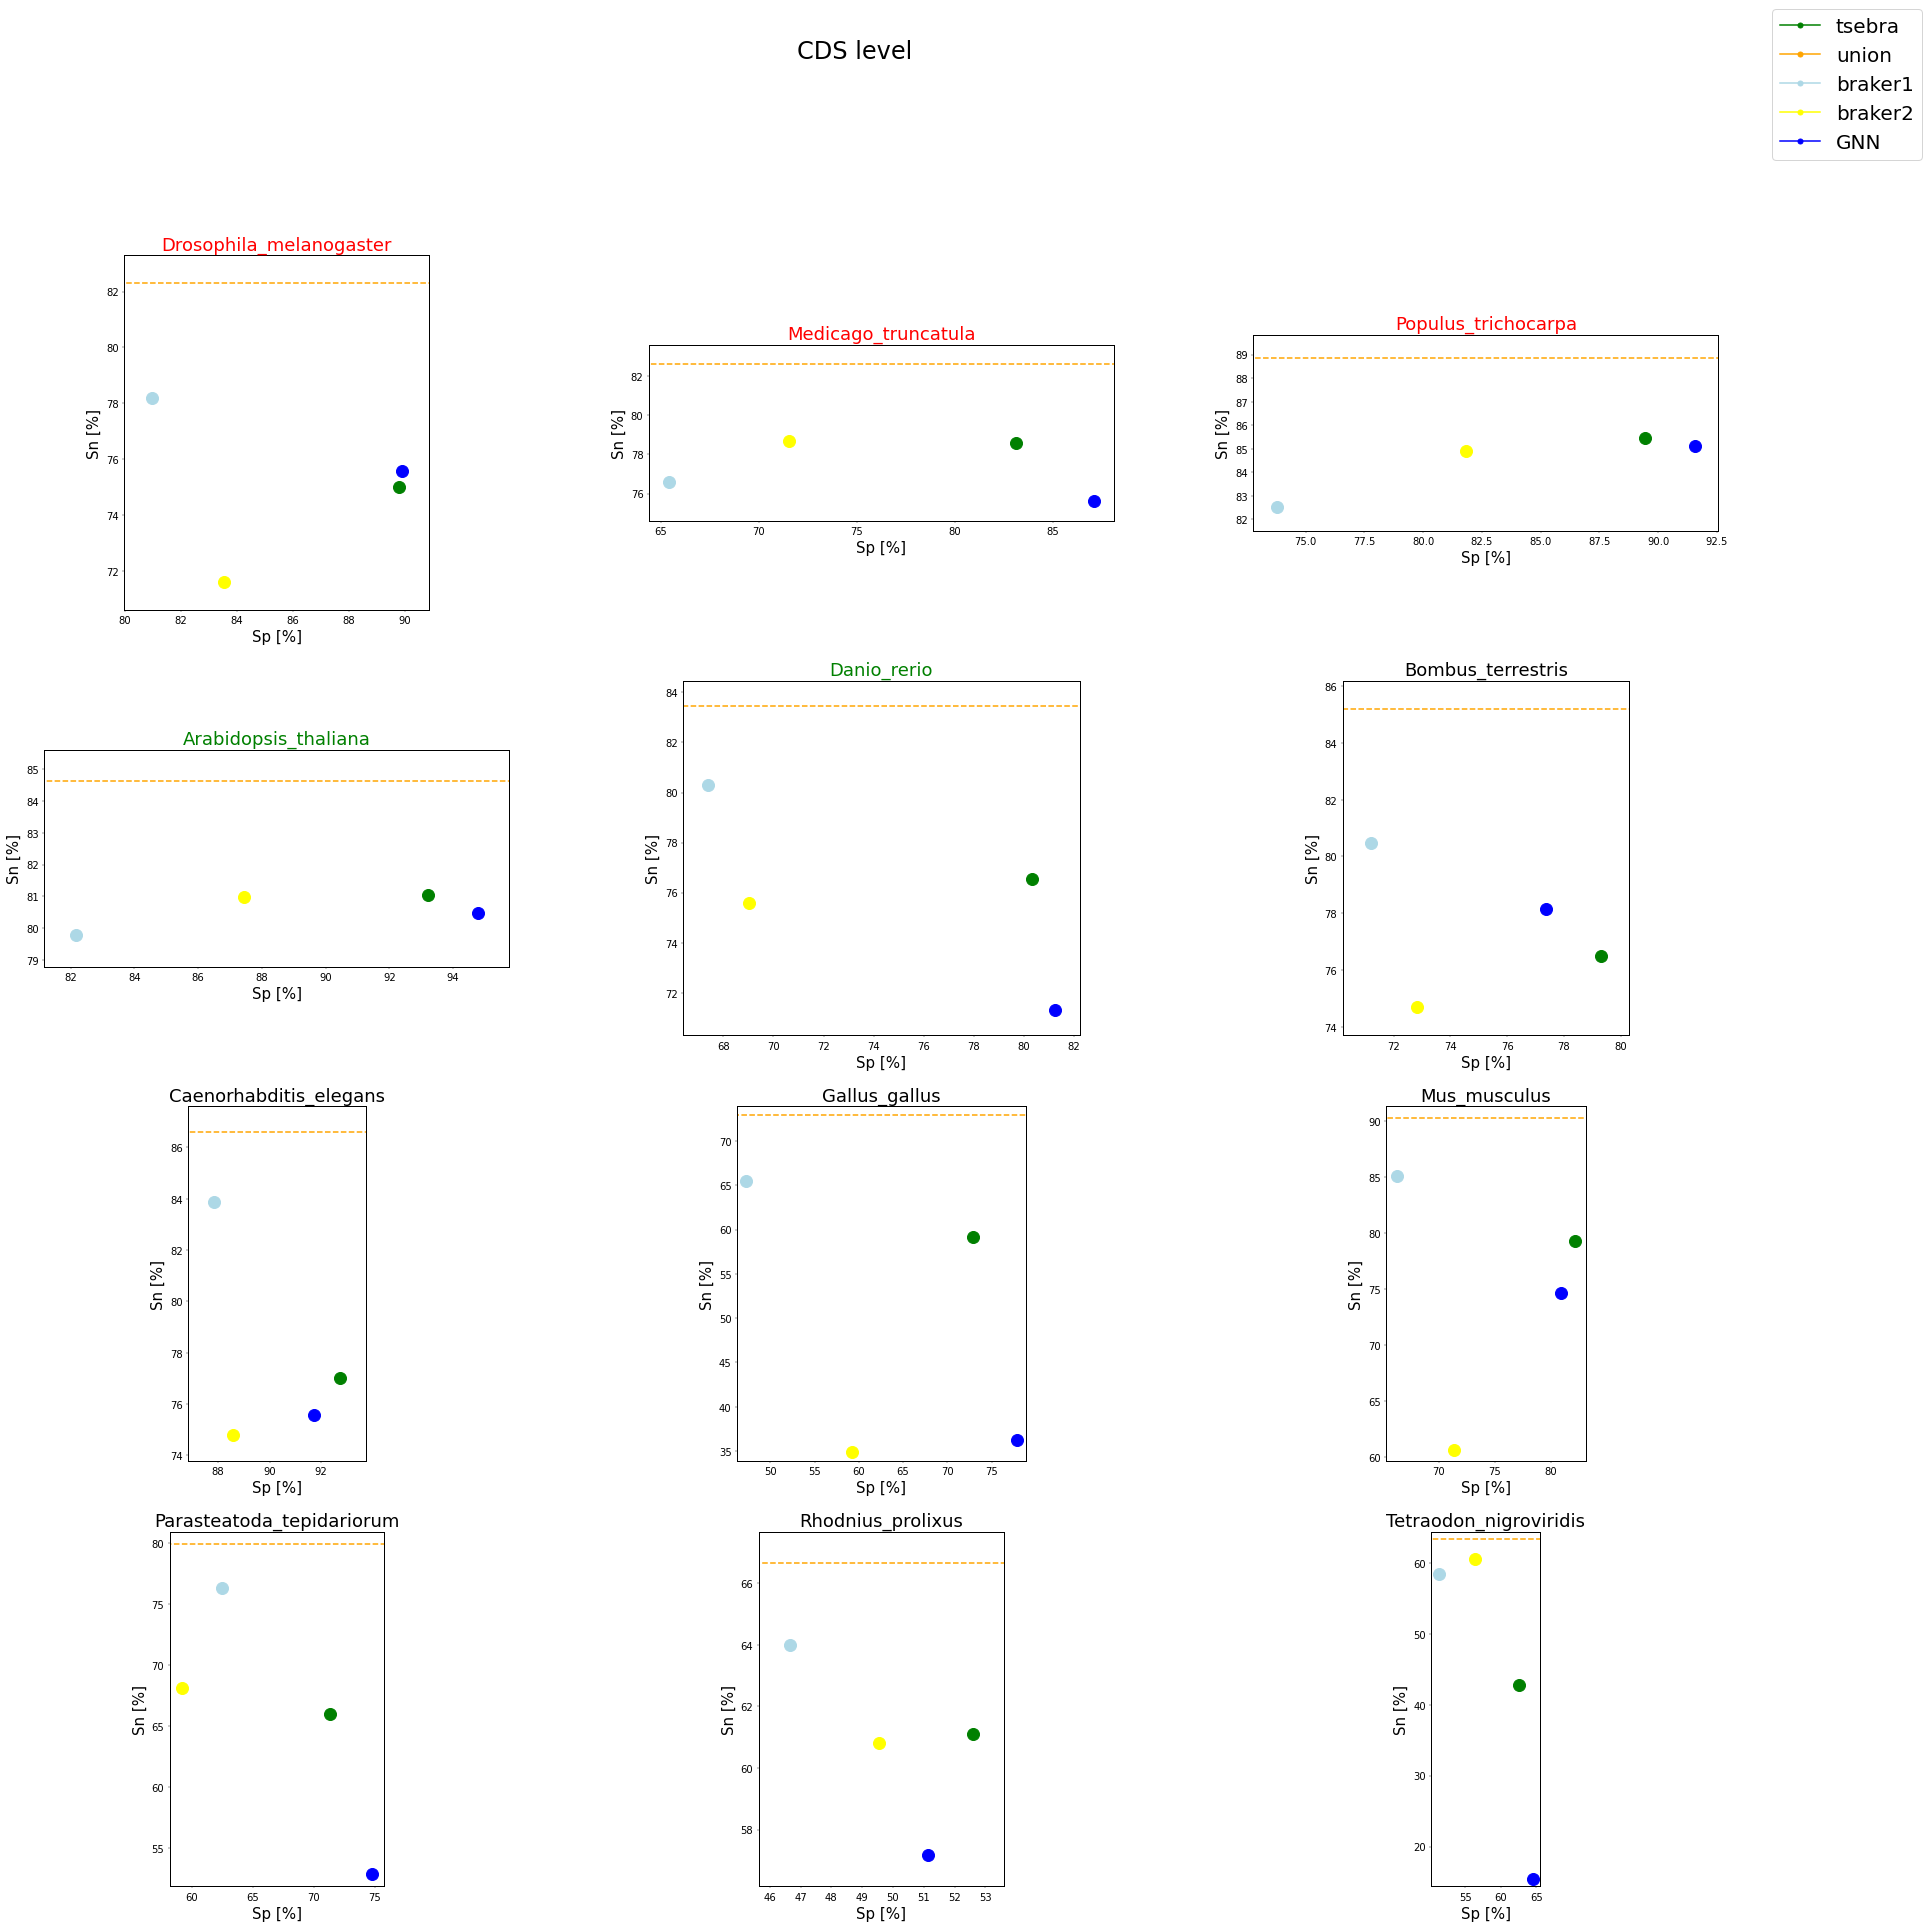

In [14]:
lvl = 'CDS'
cols = 3
rows = 4
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30,30))

for i, s in enumerate(species_ordered):        
    mi = [100, 100]
    ma = [0,0]
    for k, run in enumerate(run_names):
        xy = plot_data[run][lvl][s]
        axes[int(i/cols), i%cols].plot(xy[0],xy[1], marker='o', c=color[k], markersize=12)
        if 'union' in run:
            axes[int(i/cols), i%cols].plot([0, 100], [xy[1], xy[1]], linestyle='dashed', c=color[k])
        else:
            mi = [min(xy[0]-1, mi[0]), min(xy[1]-1, mi[1])]
            ma[0] = max(xy[0]+1, ma[0])
        ma[1] = max(xy[1]+1, ma[1])
    axes[int(i/cols), i%cols].set_xlim([mi[0], ma[0]])
    axes[int(i/cols), i%cols].set_ylim([mi[1], ma[1]])
    
for i, s in enumerate(species_ordered):
    c= 'black'
    if s in train_species:
        c = 'red'
    if s in val_species:
        c= 'green'
    axes[int(i/cols), i%cols].set_title(f'{s}', fontsize=18, color=c)
    #plots[e][1].set_xlim([min([x[0] for x in plot_data[e]])-2,\
        #max([x[0] for x in plot_data[e]])+2])
    #plots[e][1].set_ylim([min([x[1] for x in plot_data[e]])-2,\
        #max([x[1] for x in plot_data[e]])+2])
    axes[int(i/cols), i%cols].tick_params(axis='both', \
        which='major', labelsize=10)
    axes[int(i/cols), i%cols].tick_params(axis='both', \
        which='minor', labelsize=7)
    axes[int(i/cols), i%cols].tick_params(width=0.4, length=2)
    axes[int(i/cols), i%cols].set_aspect('equal')
    axes[int(i/cols), i%cols].set_xlabel('Sp [%]', fontsize=15)
    axes[int(i/cols), i%cols].set_ylabel('Sn [%]', fontsize=15)

    for axis in ['top','bottom','left','right']:
        axes[int(i/cols), i%cols].spines[axis].set_linewidth(1)
fig.suptitle(f'{lvl} level')
#fig.tight_layout()
#plots[e][0].subplots_adjust(right=0.02)
fig.legend(handles=leg, loc='upper right')
#fig.suptitle(f'{e} level')
fig.subplots_adjust(wspace=0.3);
plt.savefig(out + f'plot/species_acc_gnn_{lvl}.png', dpi=200)

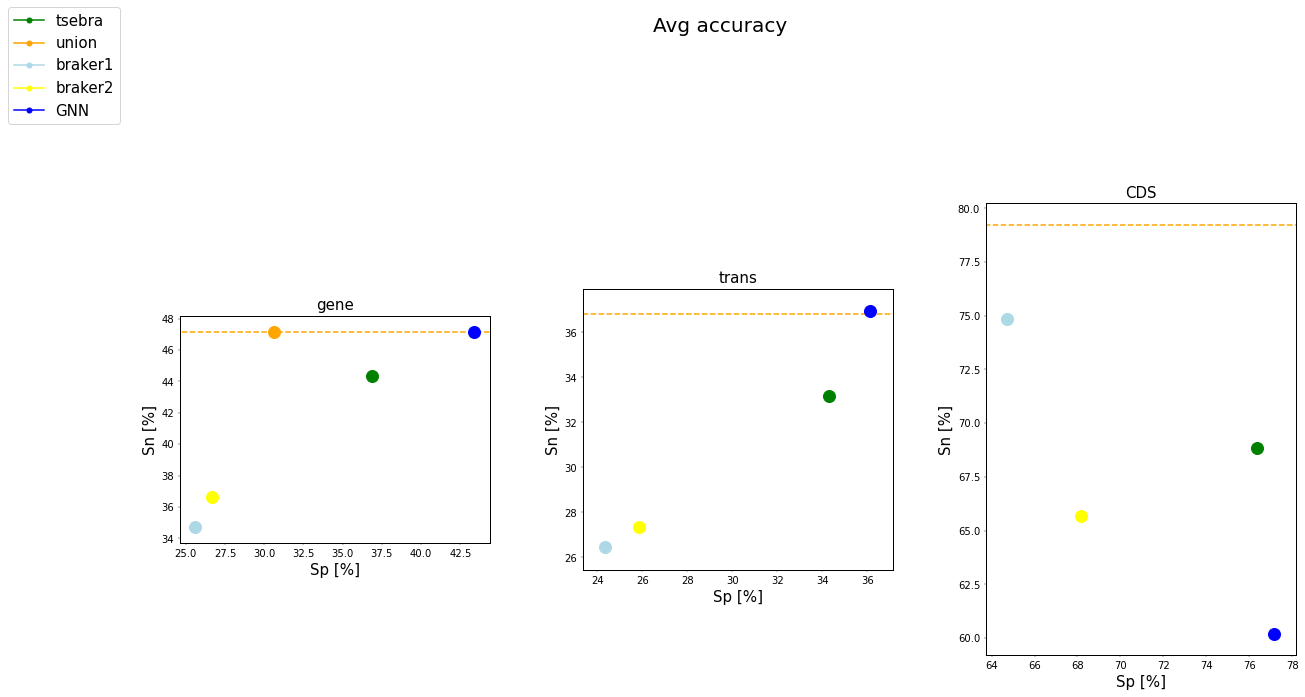

In [15]:
species_ordered = ['Caenorhabditis_elegans','Parasteatoda_tepidariorum', 
                 'Arabidopsis_thaliana', 
                 'Bombus_terrestris', 'Rhodnius_prolixus',
                'Populus_trichocarpa', 'Danio_rerio', 
               'Drosophila_melanogaster', 'Medicago_truncatula', 'Tetraodon_nigroviridis']#val_species + test_species #+ train_species
species_ordered = val_species + test_species #+ train_species
cols = 3
rows = 1
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,12))


for i, e in enumerate(eval_level):   
    mi = [100, 100]
    ma = [0,0]
    for k, run in enumerate(run_names): 
        x = []
        y = []
        for s in species_ordered:
            x.append(plot_data[run][e][s][0])
            y.append(plot_data[run][e][s][1])
        x_mean = sum(x)/len(x)
        y_mean = sum(y)/len(y)
        axes[i].plot(x_mean, y_mean, marker='o', c=color[k], markersize=12)            
        if 'union' in run:
                axes[i].plot([0, 100], [y_mean, y_mean], linestyle='dashed', c=color[k])
        else:
            mi = [min(x_mean-1, mi[0]), min(y_mean-1, mi[1])]
            ma[0] = max(x_mean+1, ma[0])
        ma[1] = max(y_mean+1, ma[1])
    axes[i].set_xlim([mi[0], ma[0]])
    axes[i].set_ylim([mi[1], ma[1]])
    
for i, s in enumerate(eval_level):
    axes[i].set_title(f'{s}', fontsize=15)
    #plots[e][1].set_xlim([min([x[0] for x in plot_data[e]])-2,\
        #max([x[0] for x in plot_data[e]])+2])
    #plots[e][1].set_ylim([min([x[1] for x in plot_data[e]])-2,\
        #max([x[1] for x in plot_data[e]])+2])
    axes[i].tick_params(axis='both', \
        which='major', labelsize=10)
    axes[i].tick_params(axis='both', \
        which='minor', labelsize=7)
    axes[i].tick_params(width=0.4, length=2)
    axes[i].set_aspect('equal')
    axes[i].set_xlabel('Sp [%]', fontsize=15)
    axes[i].set_ylabel('Sn [%]', fontsize=15)

    for axis in ['top','bottom','left','right']:
        axes[i].spines[axis].set_linewidth(1)
#fig.tight_layout()
#plots[e][0].subplots_adjust(right=0.02)
fig.legend(handles=leg, loc='upper left')
fig.suptitle(f'Avg accuracy', fontsize=20)
fig.subplots_adjust(wspace=0.3);
plt.savefig(out + 'plot/avg_acc_gnn_test.png', dpi=200)

In [14]:
data = {}

for s in species:
    if not s in data:
        data.update({s :{}})
    for r in run_names:
        if not r in data[s]:
            data[s].update({r : 0})
            a = Anno(f'{out}/{s}/{r}.gtf', f'anno_new')
            a.addGtf()
            data[s][r] = [len(a.transcripts), len(a.genes)]
            
import sys
!{sys.executable} -m pip install texttable
from texttable import Texttable

tab = [[''] + [f"{s.split('_')[0][0]}._{s.split('_')[1][:3]}." for s in species]]
for i, r in enumerate(run_names):
    tab.append([run_labels[i]] + [data[s][r][0] for s in species])
table = Texttable()
table.set_max_width(0)
table.add_rows(tab)
print(table.draw())
print('\n\n')

tab = [[''] + [f"{s.split('_')[0][0]}._{s.split('_')[1][:3]}." for s in species]]
for i, r in enumerate(run_names):
    tab.append([run_labels[i]] + [data[s][r][1] for s in species])
table = Texttable()
table.set_max_width(0)
table.add_rows(tab)
print(table.draw())
print('\n\n')

tab = [[''] + [f"{s.split('_')[0][0]}._{s.split('_')[1][:3]}." for s in species]]
for i, r in enumerate(run_names):
    tab.append([run_labels[i]] + [data[s][r][0]/data[r][s][1] for s in species])
table = Texttable()
table.set_max_width(0)
table.add_rows(tab)
print(table.draw())
print('\n\n')

KeyError: 'tsebra'

In [55]:
import sys
!{sys.executable} -m pip install texttable
from texttable import Texttable

tab = [[''] + [f"{s.split('_')[0][0]}._{s.split('_')[1][:3]}." for s in species]]
for r in run_names:
    tab.append([r] + [data[s][r] for s in species])
table = Texttable()
table.set_max_width(0)
table.add_rows(tab)
print(table.draw())
print('\n\n')

+--------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|              | A._tha. | B._ter. | C._ele. | D._rer. | D._mel. | G._gal. | M._tru. | M._mus. | P._tep. | P._tri. | R._pro. | T._nig. |
+==============+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+
| tsebra       | 28363   | 18253   | 18558   | 41725   | 14109   | 21763   | 39720   | 38742   | 32679   | 37997   | 21224   | 20624   |
+--------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
| union        | 42754   | 32076   | 31315   | 89187   | 22092   | 58816   | 70299   | 84130   | 64833   | 63994   | 38947   | 55261   |
+--------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
| braker1      | 29424   | 20328   | 2236

In [21]:
            
import sys
!{sys.executable} -m pip install texttable
from texttable import Texttable

tab = [[''] + [f"{s.split('_')[0][0]}._{s.split('_')[1][:3]}." for s in species] + ['AVG']]
for i, r in enumerate(run_names):
    tab.append([run_labels[i]] + [data[s][r][0] for s in species] + [sum([data[s][r][0] for s in species])/len(species)])
table = Texttable()
table.set_max_width(0)
table.add_rows(tab)
print('\n\nNUMBER OF TX')
print(table.draw())
print('\n\n')

tab = [[''] + [f"{s.split('_')[0][0]}._{s.split('_')[1][:3]}." for s in species] + ['AVG']]
for i, r in enumerate(run_names):
    tab.append([run_labels[i]] + [data[s][r][1] for s in species] + [sum([data[s][r][1] for s in species])/len(species)])
table = Texttable()
table.set_max_width(0)
table.add_rows(tab)
print('NUMBER OF GENES')
print(table.draw())
print('\n\n')

tab = [[''] + [f"{s.split('_')[0][0]}._{s.split('_')[1][:3]}." for s in species] + ['AVG']]
for i, r in enumerate(run_names):
    tab.append([run_labels[i]] + [data[s][r][0]/data[s][r][1] for s in species] + [sum([data[s][r][0]/data[s][r][1] for s in species])/len(species)])
table = Texttable()
table.set_max_width(0)
table.add_rows(tab)
print('NUMBER OF TX/GENE')
print(table.draw())
print('\n\n')



NUMBER OF TX
+----------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------------+
|                | A._tha. | B._ter. | C._ele. | D._rer. | D._mel. | G._gal. | M._tru. | M._mus. | P._tep. | P._tri. | R._pro. | T._nig. |    AVG     |
+================+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+=========+============+
| tsebra         | 28363   | 18253   | 18558   | 41725   | 14109   | 21763   | 39720   | 38742   | 32679   | 37997   | 21224   | 20624   | 27813.083  |
+----------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------------+
| tsebra_altseqs | 30988   | 20105   | 22228   | 46468   | 16392   | 30380   | 45245   | 45516   | 35115   | 40792   | 26359   | 27231   | 32234.917  |
+----------------+---------+---------+---------+---------+---------+-----

In [15]:
data

{'Arabidopsis_thaliana': {'tsebra': [28363, 26010],
  'tsebra_altseqs': [30988, 26720],
  'union': [42754, 30085],
  'union_altseqs': [69504, 29397],
  'braker1': [29424, 27985],
  'braker2': [30826, 29568],
  'train20_save': [25502, 23509],
  'train20_save_altseqs': [23800, 22123],
  'train22_save': [23115, 20351],
  'train22_save_altseqs': [24570, 21630]},
 'Bombus_terrestris': {'tsebra': [18253, 16840],
  'tsebra_altseqs': [20105, 16416],
  'union': [32076, 20744],
  'union_altseqs': [55960, 18901],
  'braker1': [20328, 17676],
  'braker2': [20294, 19508],
  'train20_save': [21367, 15708],
  'train20_save_altseqs': [20151, 13704],
  'train22_save': [16343, 12721],
  'train22_save_altseqs': [17344, 12150]},
 'Caenorhabditis_elegans': {'tsebra': [18558, 16968],
  'tsebra_altseqs': [22228, 18220],
  'union': [31315, 19580],
  'union_altseqs': [62601, 18738],
  'braker1': [22362, 20095],
  'braker2': [19231, 18784],
  'train20_save': [20930, 16079],
  'train20_save_altseqs': [21098, 153